In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [2]:
from torchsummary import summary

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from functools import partial

In [4]:
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader

In [5]:
torch.__version__

'1.8.0'

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [7]:
## computes output shape for both convolutions and pooling layers
def output_shape(in_dim,stride,padding,kernel,dilation=1):
    out_dim = np.floor((in_dim + 2*padding - dilation*(kernel-1)-1)/stride+1).astype(int)
    return out_dim

def output_shape_transpose(in_dim,stride,padding,kernel,output_padding, dilation=1):
    out_dim = (in_dim-1)*stride-2*padding+dilation*(kernel-1)+output_padding+1
    return out_dim

In [8]:
output_shape(np.arange(5),stride=1,padding=0,kernel=1)

array([0, 1, 2, 3, 4])

In [9]:
def get_dilation(out_dim,in_dim,stride,padding,kernel,output_padding):
    dilation = np.floor((out_dim-(in_dim-1)*stride+2*padding-output_padding-1)/(kernel-1))
    new_dim  = output_shape_transpose(in_dim,stride,padding,kernel,output_padding, dilation)
    if new_dim == out_dim:
        pass
    else:
        output_padding = (out_dim-new_dim)
    return dilation, output_padding

def get_output_padding(in_dim,out_dim, stride,padding,kernel,dilation=1):
    return out_dim-(in_dim-1)*stride+2*padding-dilation*(kernel-1)-1

In [10]:
class Reshape(nn.Module):
    def __init__(self, shape):
        super(Reshape, self).__init__()
        self.shape = shape

    def forward(self, x):
        return x.view(*self.shape)

In [11]:
class FCEncoder(nn.Module):
    def __init__(self, params, nparams):
        super(FCEncoder, self).__init__()
        if params['dim'] == '1D':
            self.N    = 1
        elif params['dim'] == '2D':
            self.N    = 2
        else:
            raise Exception("Invalid data dimensionality (must be either 1D or 2D).")
            
            
        if nparams['spec_norm']:
            spec_norm = nn.utils.spectral_norm
        else:
            spec_norm = nn.Identity()
            
        self.model = nn.ModuleList()
    
        self.model.append(nn.Flatten())
        
        current_dim = params['input_dim']**self.N*params['input_c']
        
        for ii in range(nparams['n_layers']):
            
            lin = nn.Linear(current_dim, nparams['out_sizes'][ii])
            self.model.append(spec_norm(lin))
            
            current_dim      =  nparams['out_sizes'][ii]
            
            if nparams['layer_norm'][ii]:
                norm = nn.LayerNorm(current_dim,elementwise_affine=nparams['affine'])
                self.model.append(norm)
            
            gate = getattr(nn, nparams['activations'][ii])()
            self.model.append(gate)
            
            dropout = nn.Dropout(nparams['dropout_rate'][ii])
            self.model.append(dropout)
        
        lin = nn.Linear(current_dim,params['latent_dim'])
        self.model.append(spec_norm(lin))
        
    def forward(self, x):
        for i, l in enumerate(self.model):
            x = l(x)
        return x

In [12]:
class ConvEncoder(nn.Module):
    def __init__(self, params, nparams):
        super(ConvEncoder, self).__init__()
        if params['dim'] == '1D':
            self.conv = nn.Conv1d
            self.pool = nn.AdaptiveMaxPool1d#nn.MaxPool1d
            self.N    = 1
        elif params['dim'] == '2D':
            self.conv = nn.Conv2d
            self.pool = nn.AdaptiveMaxPool2d
            self.N    = 2
        else:
            raise Exception("Invalid data dimensionality (must be either 1D or 2D).")
            
        if nparams['spec_norm']:
            spec_norm = nn.utils.spectral_norm
        else:
            spec_norm = nn.Identity()
            
        self.model = nn.ModuleList()
    
        current_channels   = params['input_c']
        current_dim        = params['input_dim']
        self.out_dims      = []
        
        for ii in range(nparams['n_layers']):
            
            conv = self.conv(current_channels, nparams['out_channels'][ii], nparams['kernel_sizes'][ii], nparams['strides'][ii], nparams['paddings'][ii])
            self.out_dims.append(current_dim)
            self.model.append(spec_norm(conv))
            
            current_channels =  nparams['out_channels'][ii]
            current_dim      =  output_shape(current_dim, nparams['strides'][ii], nparams['paddings'][ii],nparams['kernel_sizes'][ii])
            
            if nparams['layer_norm'][ii]:
                norm = nn.LayerNorm([current_channels]+[current_dim]*self.N,elementwise_affine=nparams['affine'])
                self.model.append(norm)
                
            gate = getattr(nn, nparams['activations'][ii])()
            self.model.append(gate)
            
            pool = self.pool([current_dim//nparams['scale_facs'][ii]]*self.N)
            self.model.append(pool)
            
            current_dim = current_dim//nparams['scale_facs'][ii]

        self.final_dim = current_dim
        self.final_c   = current_channels
        
        self.model.append(nn.Flatten())
        current_shape = current_channels*current_dim**self.N
        linear        = nn.Linear(current_shape,params['latent_dim'])
        self.model.append(spec_norm(linear))
            
    def forward(self, x):
        for i, l in enumerate(self.model):

            x = l(x)

        return x

In [13]:
class ConvDecoder(nn.Module):
    def __init__(self, params, nparams):
        super(ConvDecoder, self).__init__()
        
        if params['dim'] == '1D':
            self.conv = nn.ConvTranspose1d
            self.N    = 1
        elif params['dim'] == '2D':
            self.conv = nn.ConvTranspose2d
            self.N    = 2
        else:
            raise Exception("Invalid data dimensionality (must be either 1D or 2D).")
            
        if nparams['spec_norm']:
            spec_norm = nn.utils.spectral_norm
        else:
            spec_norm = nn.Identity()
        
        self.pool   = nn.Upsample
        
        self.model  = nn.ModuleList()
        
        final_shape = nparams['final_c']*nparams['final_dim']**self.N
    
        self.model.append(nn.Flatten())
        lin         = nn.Linear(params['latent_dim'],final_shape)
        self.model.append(spec_norm(lin))

        if params['dim'] == '1D':
            self.model.append(Reshape((-1, nparams['final_c'],nparams['final_dim'])))
        else:
            self.model.append(Reshape((-1, nparams['final_c'],nparams['final_dim'],nparams['final_dim'])))
                              
        current_dim      = nparams['final_dim']
        current_channels = nparams['final_c']
            
        for jj in range(1,nparams['n_layers']+1):
            ii = nparams['n_layers'] - jj 
            gate = getattr(nn, nparams['activations'][ii])()
            self.model.append(gate)
                  
            upsample    = nn.Upsample(scale_factor=nparams['scale_facs'][ii])
            self.model.append(upsample)
            current_dim = current_dim*nparams['scale_facs'][ii]
                              
            output_padding = get_output_padding(current_dim,nparams['out_dims'][ii],nparams['strides'][ii],nparams['paddings'][ii],nparams['kernel_sizes'][ii],dilation=1)
            conv           = self.conv(current_channels, nparams['out_channels'][ii], kernel_size=nparams['kernel_sizes'][ii], stride=nparams['strides'][ii], padding=nparams['paddings'][ii], output_padding=output_padding)
            self.model.append(spec_norm(conv))
            
            current_channels = nparams['out_channels'][ii]
            current_dim      = output_shape_transpose(current_dim, stride=nparams['strides'][ii], padding=nparams['paddings'][ii],kernel=nparams['kernel_sizes'][ii],output_padding=output_padding)
                
            if nparams['layer_norm'][ii]:
                norm = nn.LayerNorm([current_channels]+[current_dim]*self.N,elementwise_affine=nparams['affine'])
                self.model.append(norm)    
                
        
        conv = self.conv(current_channels, 1, kernel_size=1, stride=1)
        self.model.append(spec_norm(conv))
        
        if nparams['image_data']: 
            self.model.append(getattr(nn, 'Sigmoid')())
        
    def forward(self, x):
        for i, l in enumerate(self.model):
            x = l(x)
        return x

In [14]:
class FCDecoder(nn.Module):
    def __init__(self, params, nparams):
        super(FCDecoder, self).__init__()
        if params['dim'] == '1D':
            self.N    = 1
        elif params['dim'] == '2D':
            self.N    = 2
        else:
            raise Exception("Invalid data dimensionality (must be either 1D or 2D).")
            
            
        if nparams['spec_norm']:
            spec_norm = nn.utils.spectral_norm
        else:
            spec_norm = nn.Identity()
            
        self.model = nn.ModuleList()
    
        self.model.append(nn.Flatten())
        
        current_dim = params['latent_dim']
        
        for jj in range(1,nparams['n_layers']+1):
            ii = nparams['n_layers'] - jj 
            
            lin = nn.Linear(current_dim, nparams['out_sizes'][ii])
            self.model.append(spec_norm(lin))
            
            current_dim      =  nparams['out_sizes'][ii]
            
            if nparams['layer_norm'][ii]:
                norm = nn.LayerNorm(current_dim,elementwise_affine=nparams['affine'])
                self.model.append(norm)
                
            gate = getattr(nn, nparams['activations'][ii])()
            self.model.append(gate)
            
            dropout = nn.Dropout(nparams['dropout_rate'][ii])
            self.model.append(dropout)
        
        lin = nn.Linear(current_dim,params['input_dim']**self.N*params['input_c'])
        self.model.append(spec_norm(lin))
        
        if nparams['image_data']: 
            self.model.append(getattr(nn, 'Sigmoid')())
        
        self.model.append(Reshape([-1]+[params['input_c']]+[params['input_dim']]*self.N))
        

        
    def forward(self, x):
        for i, l in enumerate(self.model):
            x = l(x)
        return x



In [15]:
def get_data(data, loc, batchsize):
    
    if data in dir(datasets):
        dataset = getattr(datasets,data)
    
        training_data = dataset(root=loc,train=True,download=True,transform=ToTensor())

        valid_data    = dataset(root=loc,train=False,download=True,transform=ToTensor())
    else:
        pass
    
    train_dataloader = DataLoader(training_data, batch_size=batchsize, shuffle=True)
    valid_dataloader = DataLoader(valid_data, batch_size=256, shuffle=True)
    
    return train_dataloader, valid_dataloader


In [16]:
class Autoencoder(nn.Module):
    def __init__(self, params, dparams, nparams_enc, nparams_dec, tparams):
        super(Autoencoder, self).__init__()
        
        if params['encoder_type'] == 'conv':
            self.encoder = ConvEncoder(params, nparams_enc)
            nparams_enc['out_dims']  = self.encoder.out_dims
            nparams_enc['final_dim'] = self.encoder.final_dim
            nparams_enc['final_c']   = self.encoder.final_c
        elif params['encoder_type'] == 'fc':
            self.encoder = FCEncoder(params, nparams_enc)
        else:
            raise Exception('invalid encoder type')
            
        if params['decoder_type'] == 'conv':
            self.decoder = ConvDecoder(params, nparams_dec)
        elif params['decoder_type'] == 'fc':
            self.decoder = FCDecoder(params, nparams_dec)
        else:
            raise Exception('invalid decoder type')
        
        self.optimizer = getattr(optim, tparams['optimizer'])
        self.optimizer = self.optimizer(self.parameters(),tparams['initial_lr'])
        
        self.scheduler = partial(getattr(torch.optim.lr_scheduler, tparams['scheduler']),self.optimizer)
        self.scheduler = self.scheduler(**tparams['scheduler_params'])
        
        self.criterion = getattr(nn, tparams['criterion'])()
        
        self.train_loader, valid_loader = get_data(dparams['dataset'],dparams['loc'],tparams['batchsize'])
        
        self.valid_loader = iter(valid_loader)
        
        
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
    
    
    def update_lr(self,lr):
    
        self.optimizer = getattr(optim, tparams['optimizer'])
        self.optimizer  = self.optimizer(self.parameters(),lr)
        
        self.scheduler = partial(getattr(torch.optim.lr_scheduler, tparams['scheduler']),self.optimizer)
        self.scheduler = self.scheduler(**tparams['scheduler_params'])
        
        return True
    
    
    def update_scheduler(self,scheduler, scheduler_params):
        
        self.scheduler = partial(getattr(torch.optim.lr_scheduler, scheduler),self.optimizer)
        self.scheduler = self.scheduler(**scheduler_params)
        
        return True
    
    
    def update_optimizer(self,optimizer):
        
        self.optimizer = getattr(optim, optimizer)
        self.optimizer  = self.optimizer(self.parameters(),tparams['initial_lr'])
        
        self.scheduler = partial(getattr(torch.optim.lr_scheduler, tparams['scheduler']),self.optimizer)
        self.scheduler = self.scheduler(**tparams['scheduler_params'])
        
        return True
    
    def train(self, nepochs):
        running_loss    = []
        validation_loss = []
        for epoch in range(nepochs):
            r_loss = 0
            for ii, (data, _) in enumerate(self.train_loader,0):
                data = data.to(device)
                recon = self.forward(data)
                loss  = self.criterion(recon, data)
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
                r_loss+=loss.item()
            self.scheduler.step()
            running_loss.append(r_loss/ii)
            valid_data, _ = next(self.valid_loader)
            valid_data = valid_data.to(device)
            recon      = self.forward(valid_data)
            loss       = self.criterion(recon, valid_data)
            validation_loss.append(loss)
            print(f'epoch: {epoch:d}, training loss: {running_loss[-1]:.4e}, validation loss: {loss:.4e}, learning rate: {self.scheduler.get_last_lr()[0]:.4e}')
        return running_loss, validation_loss


In [17]:
n_layers     = 3
out_channels = [16,16,16]
kernel_sizes = [4,3,2]
### stride,padding,kernel; [1,0,1] is identity
#pooling_layers = [[1,0,1], [1,0,2]]
scale_facs   = [1,1,1] 
paddings     = [0,0,0]
strides      = [2,1,1]
layer_norm   = [True,True,True]
dropout_rate = [0.,0.,0.]
spec_norm    = True
dim          = '2D'
activations  = ['ReLU', 'ReLU','ReLU']
latent_dim   = 8
input_c      = 1 
input_dim    = 28
encoder_type = 'conv'
decoder_type = 'conv'
affine       = False
out_sizes    = [256,128,64]
image_data   = True

nepochs       = 20
batchsize     = 64
initial_lr    = 1e-2

optimizer     = 'Adam'
criterion     = 'MSELoss'

scheduler     = 'ExponentialLR'
scheduler_params = {'gamma':0.95}

dataset       = 'MNIST'

In [191]:
general_params      = {'input_c': input_c, 'input_dim': input_dim, 'latent_dim': latent_dim, 'encoder_type': encoder_type, 'decoder_type': decoder_type, 'dim': dim}
conv_network_params = {'n_layers': n_layers, 'out_channels': out_channels, 'kernel_sizes': kernel_sizes, 'scale_facs': scale_facs, 'paddings': paddings,\
                       'strides': strides,'activations': activations, 'spec_norm': spec_norm, 'dropout_rate':dropout_rate, 'layer_norm': layer_norm,\
                       'affine': affine,'image_data': image_data}
fc_network_params   = {'n_layers': n_layers, 'out_sizes': out_sizes,'activations': activations, 'spec_norm': spec_norm, 'dropout_rate':dropout_rate, \
                       'layer_norm': layer_norm, 'affine': affine, 'image_data': image_data}

training_params     = {'batchsize': batchsize, 'initial_lr': initial_lr, 'optimizer': optimizer, 'criterion': criterion, \
                       'scheduler': scheduler, 'scheduler_params':scheduler_params}
data_params         = {'dataset':dataset, 'loc': '/global/cscratch1/sd/vboehm/Datasets'}

In [195]:
AE = Autoencoder(general_params,data_params,conv_network_params, conv_network_params, training_params)

In [196]:
train_features, train_labels = next(iter(AE.train_loader))

In [197]:
train_features.shape

torch.Size([64, 1, 28, 28])

In [198]:
AE.to(device)

Autoencoder(
  (encoder): ConvEncoder(
    (model): ModuleList(
      (0): Conv2d(1, 16, kernel_size=(4, 4), stride=(2, 2))
      (1): LayerNorm((16, 13, 13), eps=1e-05, elementwise_affine=False)
      (2): ReLU()
      (3): AdaptiveMaxPool2d(output_size=[13, 13])
      (4): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1))
      (5): LayerNorm((16, 11, 11), eps=1e-05, elementwise_affine=False)
      (6): ReLU()
      (7): AdaptiveMaxPool2d(output_size=[11, 11])
      (8): Conv2d(16, 16, kernel_size=(2, 2), stride=(1, 1))
      (9): LayerNorm((16, 10, 10), eps=1e-05, elementwise_affine=False)
      (10): ReLU()
      (11): AdaptiveMaxPool2d(output_size=[10, 10])
      (12): Flatten(start_dim=1, end_dim=-1)
      (13): Linear(in_features=1600, out_features=8, bias=True)
    )
  )
  (decoder): ConvDecoder(
    (model): ModuleList(
      (0): Flatten(start_dim=1, end_dim=-1)
      (1): Linear(in_features=8, out_features=1600, bias=True)
      (2): Reshape()
      (3): ReLU()
      (4): Up

In [199]:
data =  torch.randn(1,1,28,28).to('cuda')


res = AE.forward(train_features.to(device))

In [200]:
summary(AE, data.shape[1::])

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 13, 13]             272
         LayerNorm-2           [-1, 16, 13, 13]               0
              ReLU-3           [-1, 16, 13, 13]               0
 AdaptiveMaxPool2d-4           [-1, 16, 13, 13]               0
            Conv2d-5           [-1, 16, 11, 11]           2,320
         LayerNorm-6           [-1, 16, 11, 11]               0
              ReLU-7           [-1, 16, 11, 11]               0
 AdaptiveMaxPool2d-8           [-1, 16, 11, 11]               0
            Conv2d-9           [-1, 16, 10, 10]           1,040
        LayerNorm-10           [-1, 16, 10, 10]               0
             ReLU-11           [-1, 16, 10, 10]               0
AdaptiveMaxPool2d-12           [-1, 16, 10, 10]               0
          Flatten-13                 [-1, 1600]               0
           Linear-14                   

In [201]:
train_loss, valid_loss = AE.train(10)

epoch: 0, training loss: 3.0870e-02, validation loss: 2.1789e-02, learning rate: 9.5000e-03
epoch: 1, training loss: 2.0042e-02, validation loss: 1.7576e-02, learning rate: 9.0250e-03
epoch: 2, training loss: 1.8681e-02, validation loss: 1.7464e-02, learning rate: 8.5737e-03
epoch: 3, training loss: 1.7910e-02, validation loss: 1.6586e-02, learning rate: 8.1451e-03
epoch: 4, training loss: 1.7364e-02, validation loss: 1.7372e-02, learning rate: 7.7378e-03
epoch: 5, training loss: 1.6969e-02, validation loss: 1.6563e-02, learning rate: 7.3509e-03
epoch: 6, training loss: 1.6660e-02, validation loss: 1.7290e-02, learning rate: 6.9834e-03
epoch: 7, training loss: 1.6401e-02, validation loss: 1.6382e-02, learning rate: 6.6342e-03
epoch: 8, training loss: 1.6219e-02, validation loss: 1.7758e-02, learning rate: 6.3025e-03
epoch: 9, training loss: 1.6041e-02, validation loss: 1.6339e-02, learning rate: 5.9874e-03


([0.0308703372837417,
  0.02004217982427351,
  0.018680692397916775,
  0.01790957682017583,
  0.017363673610773768,
  0.016969170037700754,
  0.016659738024817967,
  0.016401116133905082,
  0.016218815382526296,
  0.016041004856334744],
 [tensor(0.0218, device='cuda:0', grad_fn=<MseLossBackward>),
  tensor(0.0176, device='cuda:0', grad_fn=<MseLossBackward>),
  tensor(0.0175, device='cuda:0', grad_fn=<MseLossBackward>),
  tensor(0.0166, device='cuda:0', grad_fn=<MseLossBackward>),
  tensor(0.0174, device='cuda:0', grad_fn=<MseLossBackward>),
  tensor(0.0166, device='cuda:0', grad_fn=<MseLossBackward>),
  tensor(0.0173, device='cuda:0', grad_fn=<MseLossBackward>),
  tensor(0.0164, device='cuda:0', grad_fn=<MseLossBackward>),
  tensor(0.0178, device='cuda:0', grad_fn=<MseLossBackward>),
  tensor(0.0163, device='cuda:0', grad_fn=<MseLossBackward>)])

In [202]:
### todos: check if things are working
### add other datasets
### convert into package
### make optuna example

In [206]:
train_loader, valid_loader = get_data(data_params['dataset'],data_params['loc'],1)

data, _  = next(iter(train_loader))

recon = AE.forward(data.to(device))

plt.imshow(np.squeeze(recon.cpu().detach().numpy()))
plt.colorbar()

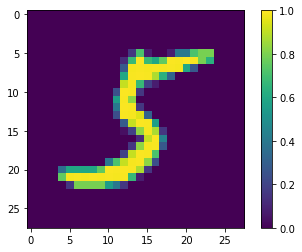

In [207]:
plt.imshow(np.squeeze(data.cpu().detach().numpy()))
plt.colorbar()